## Modeling Housing Cost  
### SVM Built from First Principles

In [68]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import sys
sys.path.append('..')

from models.svm.svm import SVMRegressor, SVMVisualizer, SVMStatistics


In [69]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'ad_housing','train.csv'))
df_test = pd.read_csv(os.path.join('..', 'data', 'raw', 'ad_housing','test.csv'))


In [70]:
def preprocess_regression_data(df, target_col, test_size=0.2,random_state=42):
    cols_to_drop = [target_col]
    if 'Id' in df.columns:
        cols_to_drop.append('Id')
    
    X = df.drop(columns=cols_to_drop)
    y = df[target_col]
    
    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Numeric features: {len(numeric_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    print(f"\nNumeric columns: {numeric_features[:5]}...")
    print(f"Categorical columns: {categorical_features[:5]}...")
    
    # Create preprocessing pipelines for numeric and categorical data
    
    # Numeric pipeline: impute with median, then scale
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # median is more robust to outliers
        ('scaler', StandardScaler())
    ])
    
    # Categorical pipeline: impute with most frequent, then one-hot encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'  # Drop any columns not specified
    )
    
    # Split the data BEFORE any transformation (avoid data leakage)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Fit preprocessor on training data and transform both train and test
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)  # Only transform, not fit
    
    print(f"\nOriginal feature count: {X.shape[1]}")
    print(f"Transformed feature count: {X_train_transformed.shape[1]}")
    print(f"(Increase due to one-hot encoding)")
    
    # Scale target variable
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
    
    print(f"\nTraining set: {X_train_transformed.shape[0]} samples")
    print(f"Test set: {X_test_transformed.shape[0]} samples")
    
    return (X_train_transformed, X_test_transformed, 
            y_train_scaled, y_test_scaled, 
            preprocessor, scaler_y, 
            numeric_features, categorical_features)

Dataset Shape: (1460, 81)

First few rows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleC

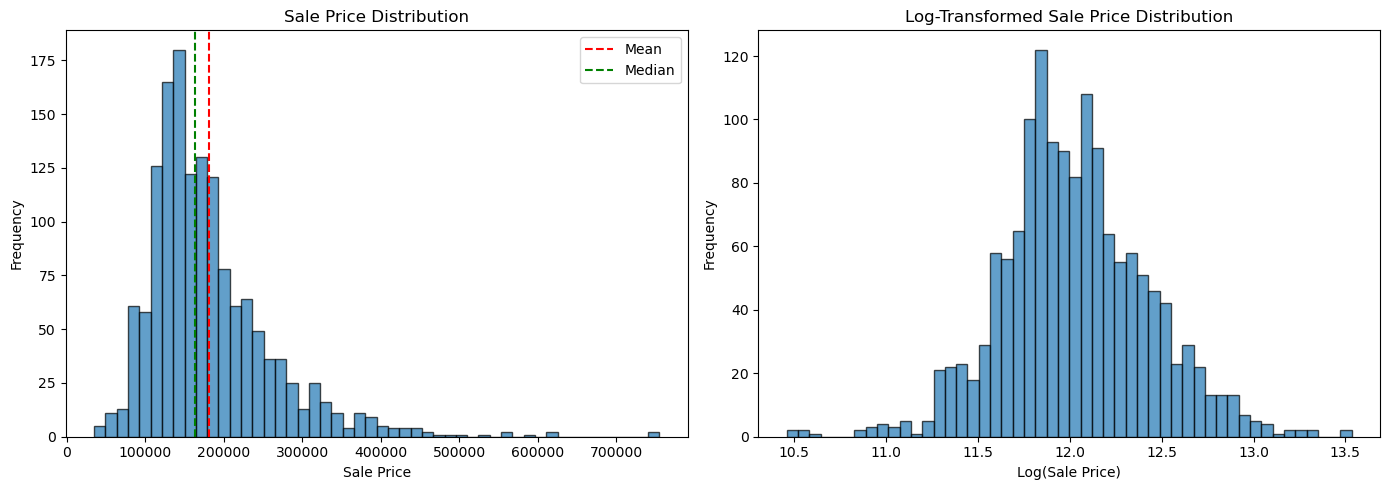

In [71]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print("\nTarget Variable (SalePrice) Statistics:")
print(df['SalePrice'].describe())

print("\nData Types:")
print(df.dtypes.value_counts())

# Visualize target distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].hist(df['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sale Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Sale Price Distribution')
axes[0].axvline(df['SalePrice'].mean(), color='r', linestyle='--', label='Mean')
axes[0].axvline(df['SalePrice'].median(), color='g', linestyle='--', label='Median')
axes[0].legend()

# Log-transformed distribution
axes[1].hist(np.log1p(df['SalePrice']), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Sale Price)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Sale Price Distribution')
plt.tight_layout()
plt.show()

In [72]:
(X_train, X_test, y_train, y_test, 
 preprocessor, scaler_y, 
 numeric_features, categorical_features) = preprocess_regression_data(
    df, target_col='SalePrice', test_size=0.2, random_state=42
)


Numeric features: 36
Categorical features: 43

Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']...
Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']...

Original feature count: 79
Transformed feature count: 242
(Increase due to one-hot encoding)

Training set: 1168 samples
Test set: 292 samples


# CELL 5: Train SVM with Linear Kernel

In [73]:
# Use subset for faster training (increase for better results)
n_samples = min(2000, X_train.shape[0])

svm_linear = SVMRegressor(
    C=1.0,
    epsilon=0.1,
    kernel='linear',
    max_iter=1000,
    tol=1e-3
)

svm_linear.fit(X_train[:n_samples], y_train[:n_samples], verbose=True)

# Predictions
y_pred_train_linear = svm_linear.predict(X_train[:n_samples])
y_pred_test_linear = svm_linear.predict(X_test)

# Evaluate
train_r2_linear = r2_score(y_train[:n_samples], y_pred_train_linear)
test_r2_linear = r2_score(y_test, y_pred_test_linear)

# Transform back to original scale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_test_linear_original = scaler_y.inverse_transform(y_pred_test_linear.reshape(-1, 1)).ravel()

rmse_linear = np.sqrt(mean_squared_error(y_test_original, y_pred_test_linear_original))
mae_linear = mean_absolute_error(y_test_original, y_pred_test_linear_original)

print(f"\nLinear Kernel Results:")
print(f"  Train R²: {train_r2_linear:.4f}")
print(f"  Test R²:  {test_r2_linear:.4f}")
print(f"  Test RMSE: ${rmse_linear:,.2f}")
print(f"  Test MAE:  ${mae_linear:,.2f}")
print(f"  Support Vectors: {len(svm_linear.support_vectors)}")

Number of support vectors: 1168

Linear Kernel Results:
  Train R²: -1069.9630
  Test R²:  -529.6470
  Test RMSE: $2,017,482.56
  Test MAE:  $1,142,741.60
  Support Vectors: 1168


# CELL 6: Train SVM with RBF Kernel

In [74]:

svm_rbf = SVMRegressor(
    C=1.0,
    epsilon=0.1,
    kernel='rbf',
    gamma='auto',
    max_iter=1000,
    tol=1e-3
)

svm_rbf.fit(X_train[:n_samples], y_train[:n_samples], verbose=True)

# Predictions
y_pred_train_rbf = svm_rbf.predict(X_train[:n_samples])
y_pred_test_rbf = svm_rbf.predict(X_test)

# Evaluate
train_r2_rbf = r2_score(y_train[:n_samples], y_pred_train_rbf)
test_r2_rbf = r2_score(y_test, y_pred_test_rbf)

y_pred_test_rbf_original = scaler_y.inverse_transform(y_pred_test_rbf.reshape(-1, 1)).ravel()

rmse_rbf = np.sqrt(mean_squared_error(y_test_original, y_pred_test_rbf_original))
mae_rbf = mean_absolute_error(y_test_original, y_pred_test_rbf_original)

print(f"\nRBF Kernel Results:")
print(f"  Train R²: {train_r2_rbf:.4f}")
print(f"  Test R²:  {test_r2_rbf:.4f}")
print(f"  Test RMSE: ${rmse_rbf:,.2f}")
print(f"  Test MAE:  ${mae_rbf:,.2f}")
print(f"  Support Vectors: {len(svm_rbf.support_vectors)}")

Number of support vectors: 1162

RBF Kernel Results:
  Train R²: 0.9022
  Test R²:  0.8815
  Test RMSE: $30,143.58
  Test MAE:  $15,693.08
  Support Vectors: 1162


In [75]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Kernel', 'RBF Kernel'],
    'Train R²': [train_r2_linear, train_r2_rbf],
    'Test R²': [test_r2_linear, test_r2_rbf],
    'RMSE ($)': [rmse_linear, rmse_rbf],
    'MAE ($)': [mae_linear, mae_rbf],
    'Support Vectors': [
        len(svm_linear.support_vectors) if svm_linear.support_vectors is not None else 0,
        len(svm_rbf.support_vectors) if svm_rbf.support_vectors is not None else 0
    ]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Select best model
best_model = svm_rbf if test_r2_rbf > test_r2_linear else svm_linear
best_name = "RBF" if test_r2_rbf > test_r2_linear else "Linear"
y_pred_best = y_pred_test_rbf if test_r2_rbf > test_r2_linear else y_pred_test_linear
y_pred_best_original = scaler_y.inverse_transform(y_pred_best.reshape(-1, 1)).ravel()

print(f"\nBest Model: {best_name} Kernel")


MODEL COMPARISON
        Model     Train R²     Test R²     RMSE ($)      MAE ($)  Support Vectors
Linear Kernel -1069.962950 -529.647040 2.017483e+06 1.142742e+06             1168
   RBF Kernel     0.902223    0.881539 3.014358e+04 1.569308e+04             1162

Best Model: RBF Kernel


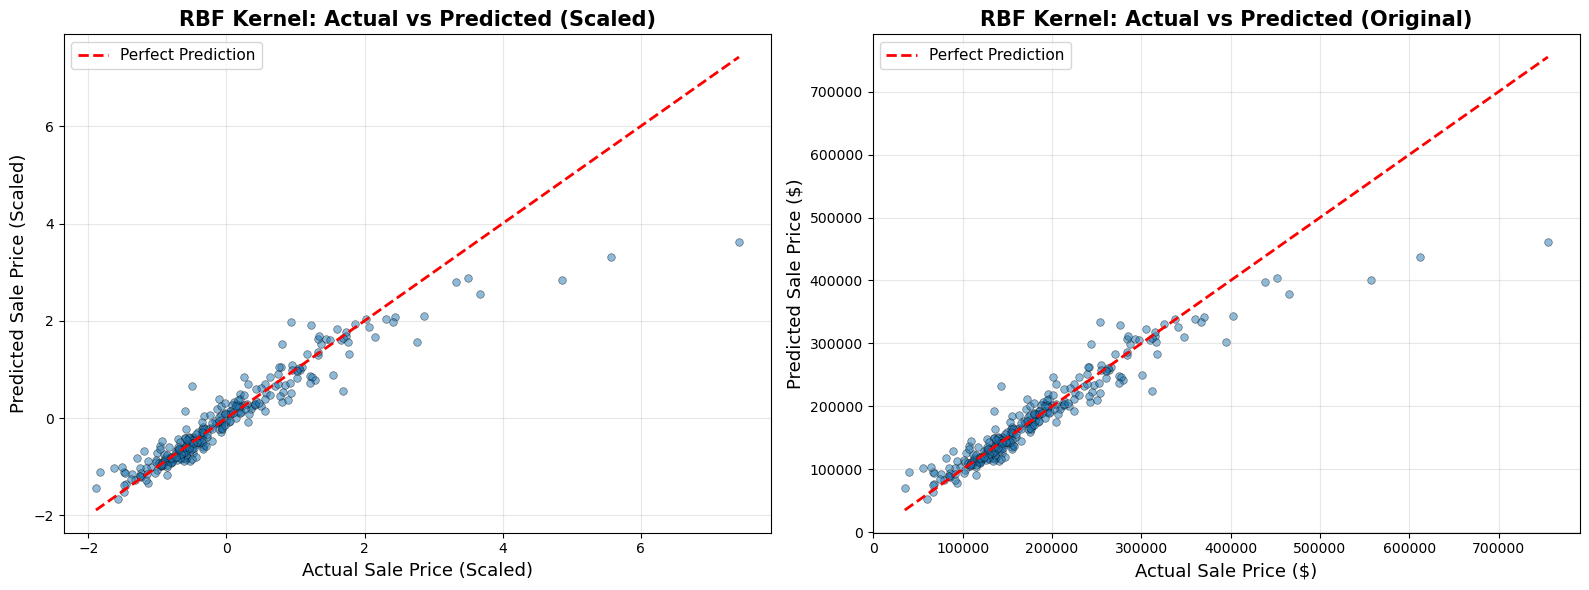

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scaled values
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Sale Price (Scaled)', fontsize=13)
axes[0].set_ylabel('Predicted Sale Price (Scaled)', fontsize=13)
axes[0].set_title(f'{best_name} Kernel: Actual vs Predicted (Scaled)', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Original scale
axes[1].scatter(y_test_original, y_pred_best_original, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
min_val = min(y_test_original.min(), y_pred_best_original.min())
max_val = max(y_test_original.max(), y_pred_best_original.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Sale Price ($)', fontsize=13)
axes[1].set_ylabel('Predicted Sale Price ($)', fontsize=13)
axes[1].set_title(f'{best_name} Kernel: Actual vs Predicted (Original)', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


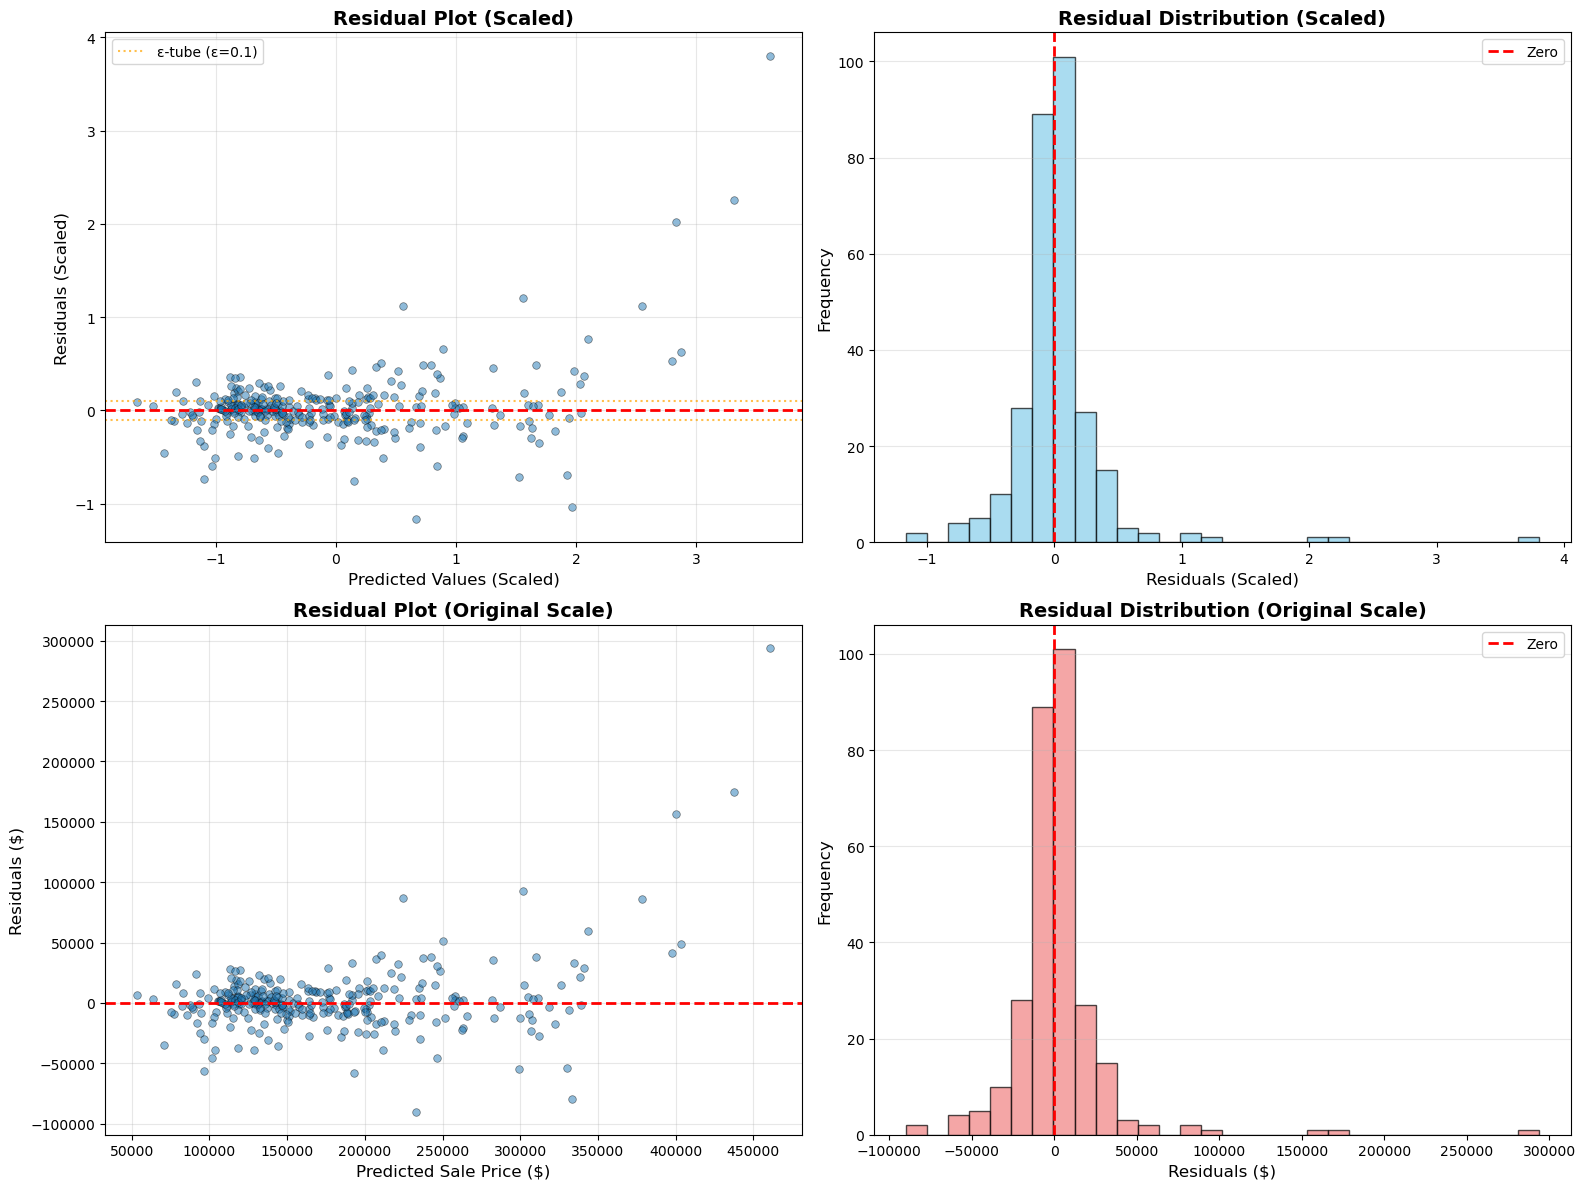

In [77]:
residuals = y_test - y_pred_best
residuals_original = y_test_original - y_pred_best_original

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residuals vs Predicted (scaled)
axes[0, 0].scatter(y_pred_best, residuals, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].axhline(y=best_model.epsilon, color='orange', linestyle=':', alpha=0.7, 
                   label=f'ε-tube (ε={best_model.epsilon})')
axes[0, 0].axhline(y=-best_model.epsilon, color='orange', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Predicted Values (Scaled)', fontsize=12)
axes[0, 0].set_ylabel('Residuals (Scaled)', fontsize=12)
axes[0, 0].set_title('Residual Plot (Scaled)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residual histogram (scaled)
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero')
axes[0, 1].set_xlabel('Residuals (Scaled)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Residual Distribution (Scaled)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Residuals vs Predicted (original scale)
axes[1, 0].scatter(y_pred_best_original, residuals_original, alpha=0.5, s=30, 
                   edgecolors='k', linewidth=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Sale Price ($)', fontsize=12)
axes[1, 0].set_ylabel('Residuals ($)', fontsize=12)
axes[1, 0].set_title('Residual Plot (Original Scale)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Residual histogram (original scale)
axes[1, 1].hist(residuals_original, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero')
axes[1, 1].set_xlabel('Residuals ($)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Residual Distribution (Original Scale)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



SVM VISUALIZER - REGRESSION FIT ANALYSIS

Creating 1D visualization using feature: GrLivArea


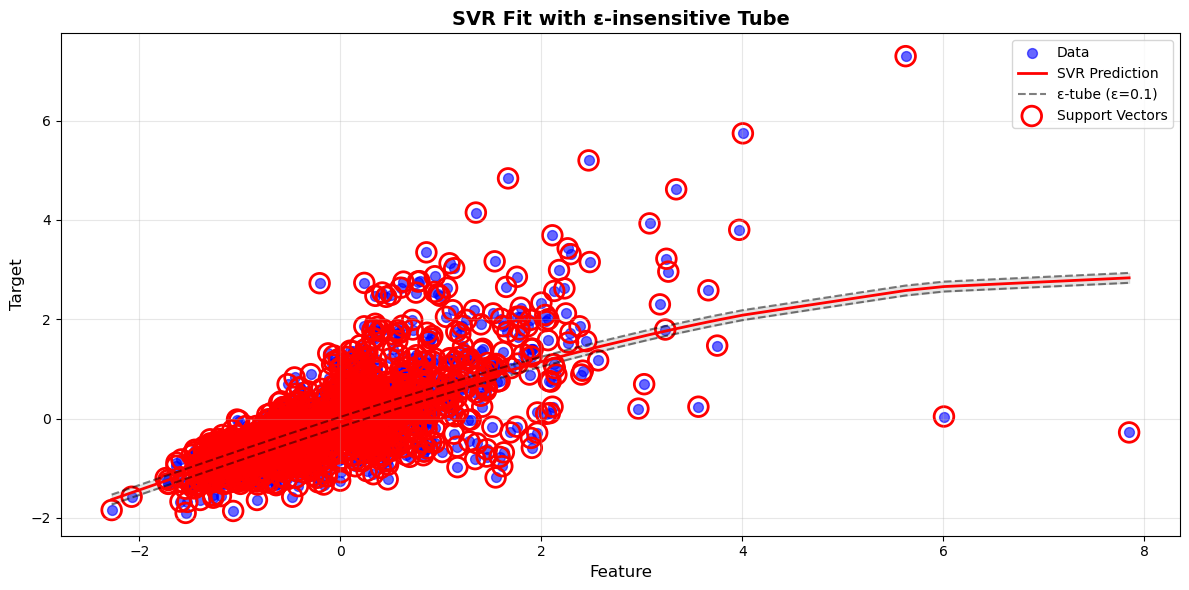


Support Vectors in 1D model: 1147


In [78]:
print("\n" + "="*70)
print("SVM VISUALIZER - REGRESSION FIT ANALYSIS")
print("="*70)

# Create visualizer for best model
viz_best = SVMVisualizer(best_model)

# For 1D visualization, use a single feature
# Let's pick the most important numeric feature (GrLivArea is usually important)
if 'GrLivArea' in df.columns:
    feature_name = 'GrLivArea'
    feature_idx = numeric_features.index(feature_name) if feature_name in numeric_features else 0
else:
    feature_idx = 0  # Use first numeric feature
    feature_name = numeric_features[0] if numeric_features else 'Feature_0'

print(f"\nCreating 1D visualization using feature: {feature_name}")

# Extract single feature for 1D visualization
X_train_1d = X_train[:n_samples, feature_idx].reshape(-1, 1)
y_train_1d = y_train[:n_samples]

# Train a 1D model for visualization
svm_1d = SVMRegressor(
    C=best_model.C,
    epsilon=best_model.epsilon,
    kernel=best_model.kernel_type,
    gamma=best_model.gamma if hasattr(best_model, 'gamma') else 'auto',
    max_iter=100
)
svm_1d.fit(X_train_1d, y_train_1d, verbose=False)

# Visualize 1D regression fit with epsilon tube
viz_1d = SVMVisualizer(svm_1d)
viz_1d.plot_regression_fit(X_train_1d, y_train_1d)

print(f"\nSupport Vectors in 1D model: {len(svm_1d.support_vectors)}")


MULTI-DIMENSIONAL REGRESSION VISUALIZATION


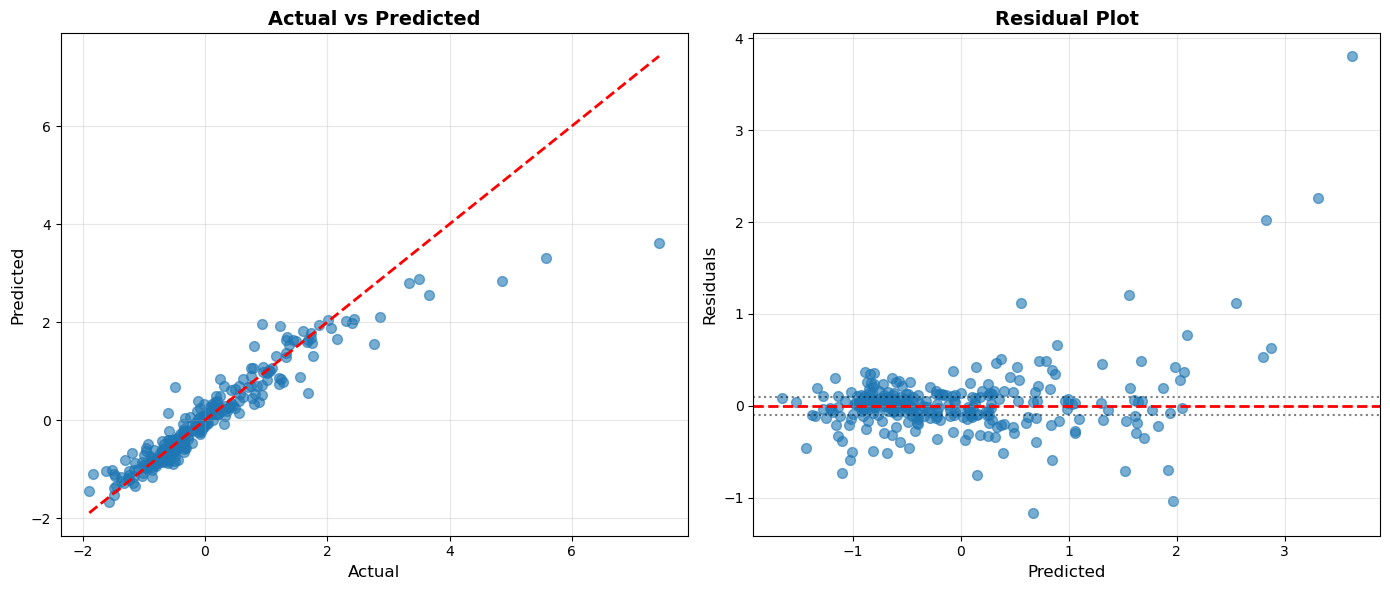


KERNEL COMPARISON VISUALIZATION
Training models on 2D data for kernel comparison...
Linear kernel - Support Vectors: 1166
RBF kernel - Support Vectors: 1161

Linear Kernel Fit:


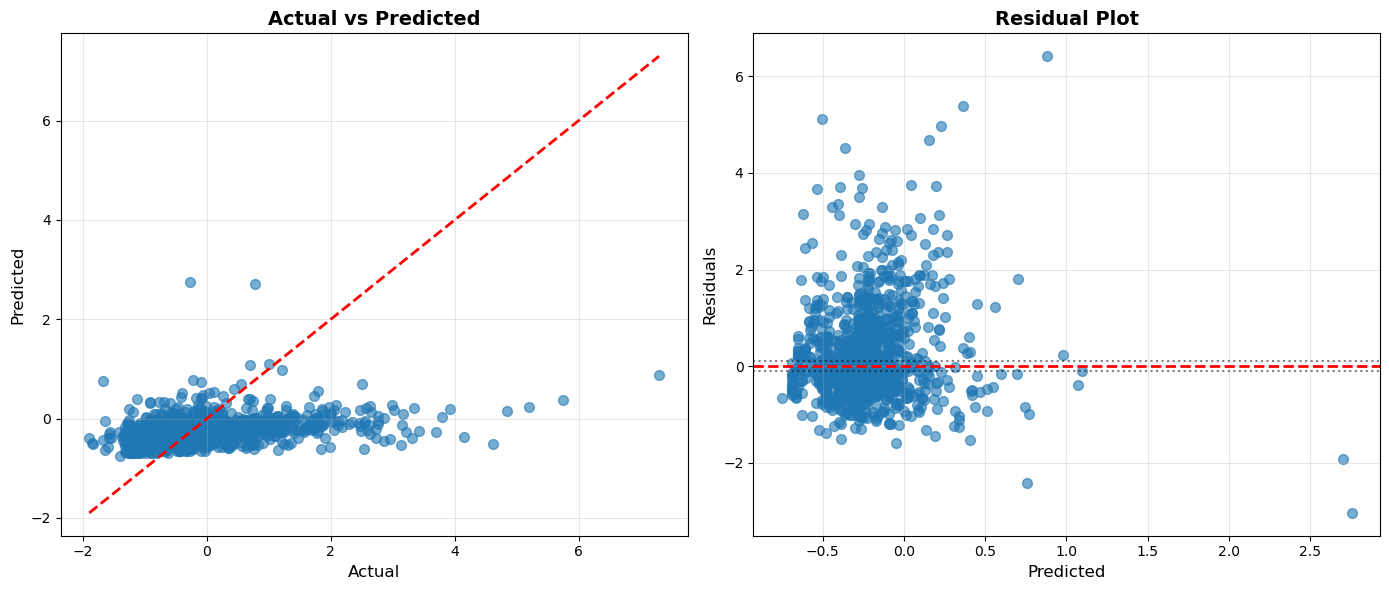


RBF Kernel Fit:


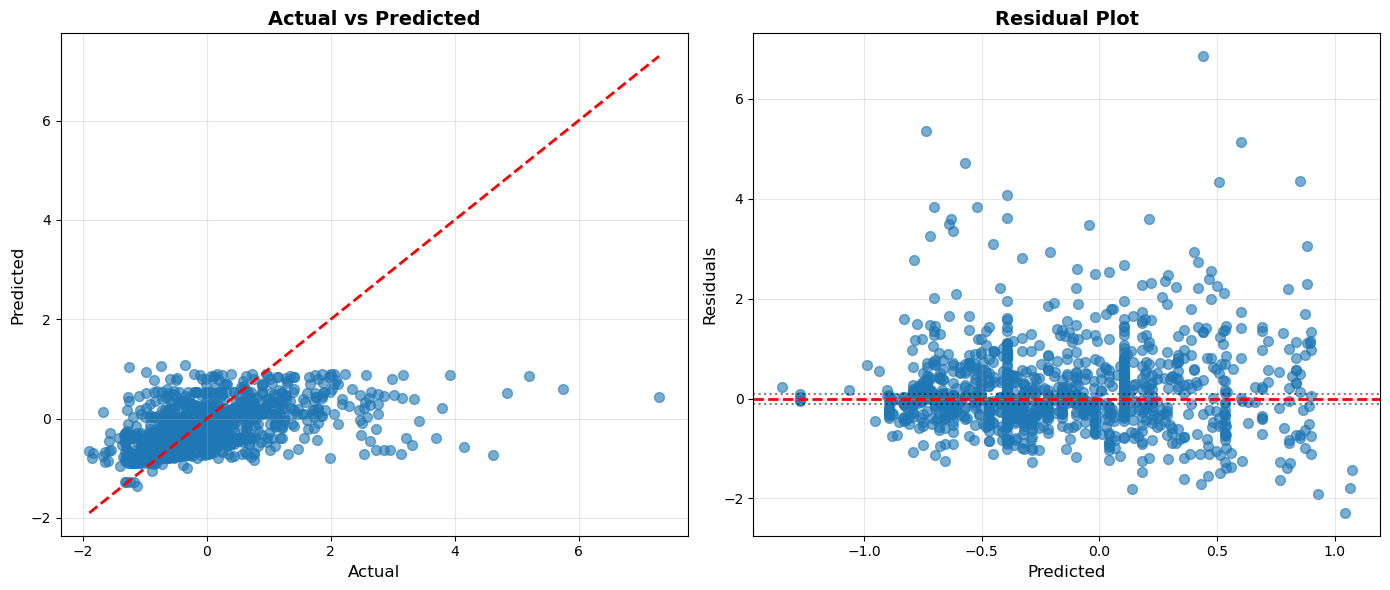

In [79]:
print("\n" + "="*70)
print("MULTI-DIMENSIONAL REGRESSION VISUALIZATION")
print("="*70)

# Use the best model for full visualization
viz_best.plot_regression_fit(X_test, y_test)

# CELL 13: Compare Linear vs RBF with SVMVisualizer
print("\n" + "="*70)
print("KERNEL COMPARISON VISUALIZATION")
print("="*70)

# For better visualization, use 2 features for 2D comparison
if X_train.shape[1] >= 2:
    # Use first 2 features
    X_train_2d = X_train[:n_samples, :2]
    y_train_2d = y_train[:n_samples]
    
    print("Training models on 2D data for kernel comparison...")
    
    # Train both kernels on 2D data
    svm_2d_linear = SVMRegressor(C=1.0, epsilon=0.1, kernel='linear', max_iter=100)
    svm_2d_rbf = SVMRegressor(C=1.0, epsilon=0.1, kernel='rbf', gamma='auto', max_iter=100)
    
    svm_2d_linear.fit(X_train_2d, y_train_2d, verbose=False)
    svm_2d_rbf.fit(X_train_2d, y_train_2d, verbose=False)
    
    print(f"Linear kernel - Support Vectors: {len(svm_2d_linear.support_vectors)}")
    print(f"RBF kernel - Support Vectors: {len(svm_2d_rbf.support_vectors)}")
    
    # Visualize both
    print("\nLinear Kernel Fit:")
    viz_2d_linear = SVMVisualizer(svm_2d_linear)
    viz_2d_linear.plot_regression_fit(X_train_2d, y_train_2d)
    
    print("\nRBF Kernel Fit:")
    viz_2d_rbf = SVMVisualizer(svm_2d_rbf)
    viz_2d_rbf.plot_regression_fit(X_train_2d, y_train_2d)


SUPPORT VECTOR ANALYSIS

Total Support Vectors: 1162
Percentage of training data: 99.49%


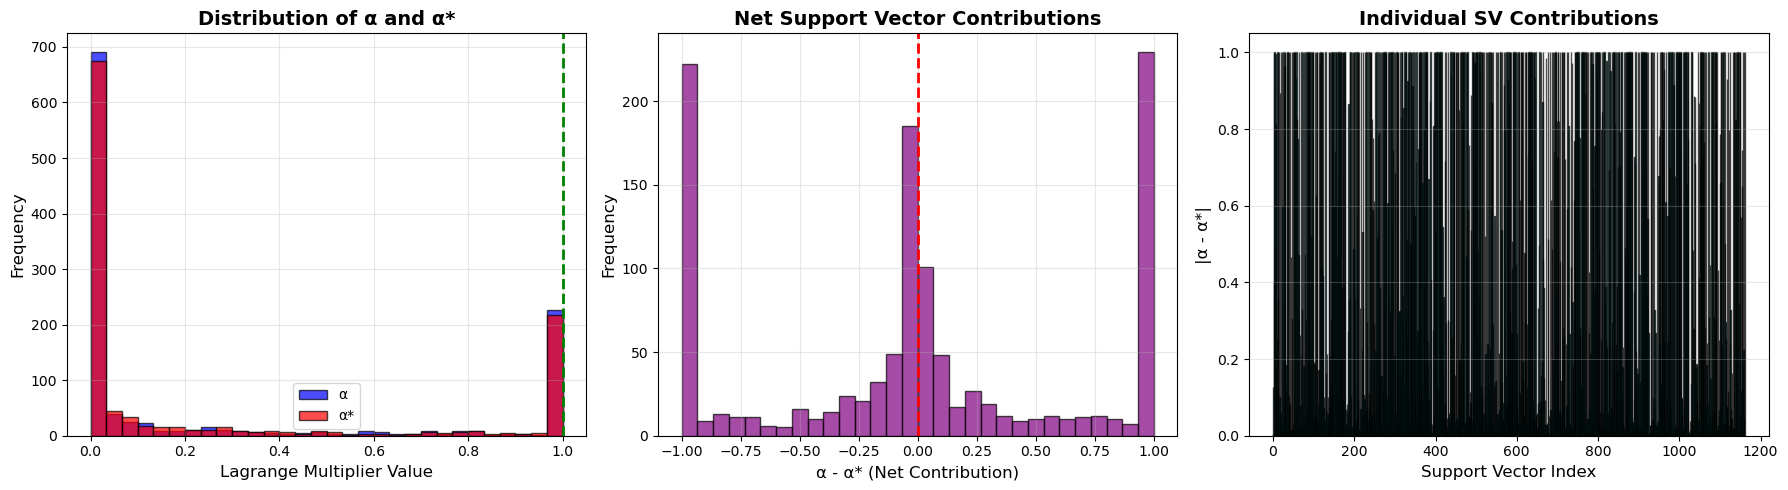


Support Vector Statistics:
  Min α: 0.000000
  Max α: 1.000000
  Mean α: 0.266514
  Min α*: 0.000000
  Max α*: 1.000000
  Mean α*: 0.264206
  Support vectors at boundary (≥0.99C): 438 (37.7%)


In [80]:
print("\n" + "="*70)
print("SUPPORT VECTOR ANALYSIS")
print("="*70)

if hasattr(best_model, 'support_vectors') and best_model.support_vectors is not None:
    print(f"\nTotal Support Vectors: {len(best_model.support_vectors)}")
    print(f"Percentage of training data: {len(best_model.support_vectors)/n_samples*100:.2f}%")
    
    # Analyze alpha values
    if hasattr(best_model, 'alpha') and hasattr(best_model, 'alpha_star'):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Alpha distribution
        alpha_diff = best_model.alpha - best_model.alpha_star
        axes[0].hist(best_model.alpha, bins=30, alpha=0.7, edgecolor='black', 
                     label='α', color='blue')
        axes[0].hist(best_model.alpha_star, bins=30, alpha=0.7, edgecolor='black',
                     label='α*', color='red')
        axes[0].set_xlabel('Lagrange Multiplier Value', fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)
        axes[0].set_title('Distribution of α and α*', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].axvline(best_model.C, color='green', linestyle='--', 
                       linewidth=2, label=f'C={best_model.C}')
        axes[0].grid(True, alpha=0.3)
        
        # Alpha - Alpha* (net contribution)
        axes[1].hist(alpha_diff, bins=30, edgecolor='black', alpha=0.7, color='purple')
        axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
        axes[1].set_xlabel('α - α* (Net Contribution)', fontsize=12)
        axes[1].set_ylabel('Frequency', fontsize=12)
        axes[1].set_title('Net Support Vector Contributions', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Support vector contributions
        sv_contributions = np.abs(alpha_diff)
        axes[2].bar(range(len(sv_contributions)), sv_contributions, 
                   alpha=0.7, edgecolor='black', color='teal')
        axes[2].set_xlabel('Support Vector Index', fontsize=12)
        axes[2].set_ylabel('|α - α*|', fontsize=12)
        axes[2].set_title('Individual SV Contributions', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print(f"\nSupport Vector Statistics:")
        print(f"  Min α: {best_model.alpha.min():.6f}")
        print(f"  Max α: {best_model.alpha.max():.6f}")
        print(f"  Mean α: {best_model.alpha.mean():.6f}")
        print(f"  Min α*: {best_model.alpha_star.min():.6f}")
        print(f"  Max α*: {best_model.alpha_star.max():.6f}")
        print(f"  Mean α*: {best_model.alpha_star.mean():.6f}")
        
        # Count support vectors at boundary (α = C or α* = C)
        at_boundary = np.sum((best_model.alpha >= best_model.C * 0.99) | 
                           (best_model.alpha_star >= best_model.C * 0.99))
        print(f"  Support vectors at boundary (≥0.99C): {at_boundary} ({at_boundary/len(best_model.alpha)*100:.1f}%)")



DETAILED ERROR ANALYSIS

Error Statistics (Original Scale):
  Mean Error: $15,693.08
  Median Error: $8,759.39
  Std Dev of Errors: $25,736.41
  Min Error: $3.59
  Max Error: $293,941.16
  25th Percentile: $3,685.25
  75th Percentile: $18,090.82

Percentage Errors:
  Mean: 9.18%
  Median: 5.20%
  < 10% error: 212 samples (72.6%)
  < 20% error: 265 samples (90.8%)
  > 50% error: 5 samples (1.7%)


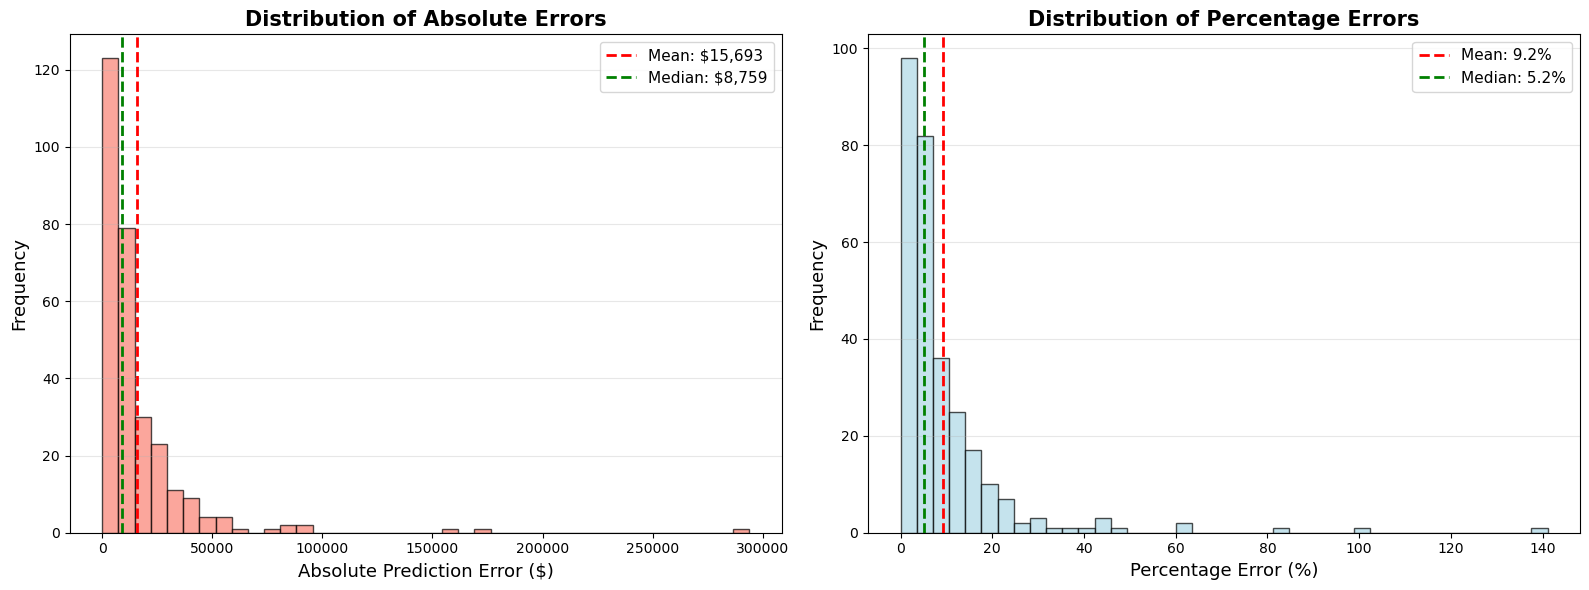

In [81]:
print("\n" + "="*70)
print("DETAILED ERROR ANALYSIS")
print("="*70)

# Calculate detailed error metrics
errors_original = np.abs(residuals_original)
mse = mean_squared_error(y_test_original, y_pred_best_original)
rmse_calc = np.sqrt(mse)

print(f"\nError Statistics (Original Scale):")
print(f"  Mean Error: ${errors_original.mean():,.2f}")
print(f"  Median Error: ${np.median(errors_original):,.2f}")
print(f"  Std Dev of Errors: ${errors_original.std():,.2f}")
print(f"  Min Error: ${errors_original.min():,.2f}")
print(f"  Max Error: ${errors_original.max():,.2f}")
print(f"  25th Percentile: ${np.percentile(errors_original, 25):,.2f}")
print(f"  75th Percentile: ${np.percentile(errors_original, 75):,.2f}")

# Percentage errors
percentage_errors = (errors_original / y_test_original) * 100
print(f"\nPercentage Errors:")
print(f"  Mean: {percentage_errors.mean():.2f}%")
print(f"  Median: {np.median(percentage_errors):.2f}%")
print(f"  < 10% error: {np.sum(percentage_errors < 10)} samples ({np.sum(percentage_errors < 10)/len(percentage_errors)*100:.1f}%)")
print(f"  < 20% error: {np.sum(percentage_errors < 20)} samples ({np.sum(percentage_errors < 20)/len(percentage_errors)*100:.1f}%)")
print(f"  > 50% error: {np.sum(percentage_errors > 50)} samples ({np.sum(percentage_errors > 50)/len(percentage_errors)*100:.1f}%)")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute errors
axes[0].hist(errors_original, bins=40, edgecolor='black', alpha=0.7, color='salmon')
axes[0].axvline(errors_original.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: ${errors_original.mean():,.0f}')
axes[0].axvline(np.median(errors_original), color='green', linestyle='--',
               linewidth=2, label=f'Median: ${np.median(errors_original):,.0f}')
axes[0].set_xlabel('Absolute Prediction Error ($)', fontsize=13)
axes[0].set_ylabel('Frequency', fontsize=13)
axes[0].set_title('Distribution of Absolute Errors', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Percentage errors
axes[1].hist(percentage_errors, bins=40, edgecolor='black', alpha=0.7, color='lightblue')
axes[1].axvline(percentage_errors.mean(), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {percentage_errors.mean():.1f}%')
axes[1].axvline(np.median(percentage_errors), color='green', linestyle='--',
               linewidth=2, label=f'Median: {np.median(percentage_errors):.1f}%')
axes[1].set_xlabel('Percentage Error (%)', fontsize=13)
axes[1].set_ylabel('Frequency', fontsize=13)
axes[1].set_title('Distribution of Percentage Errors', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


PERFORMANCE BY PRICE RANGE

          Price Range  Count        R²          RMSE          MAE  Mean Error %
      Low ($0-$150k)    139  0.531233  16791.247508 10590.771833      8.940433
Medium ($150k-$250k)    104  0.654064  15881.023359 12387.890543      6.551664
  High ($250k-$350k)     38 -0.168299  29283.546399 20676.808998      7.197271
  Very High (>$350k)     11 -0.094321 123330.873893 94200.173391     20.026468


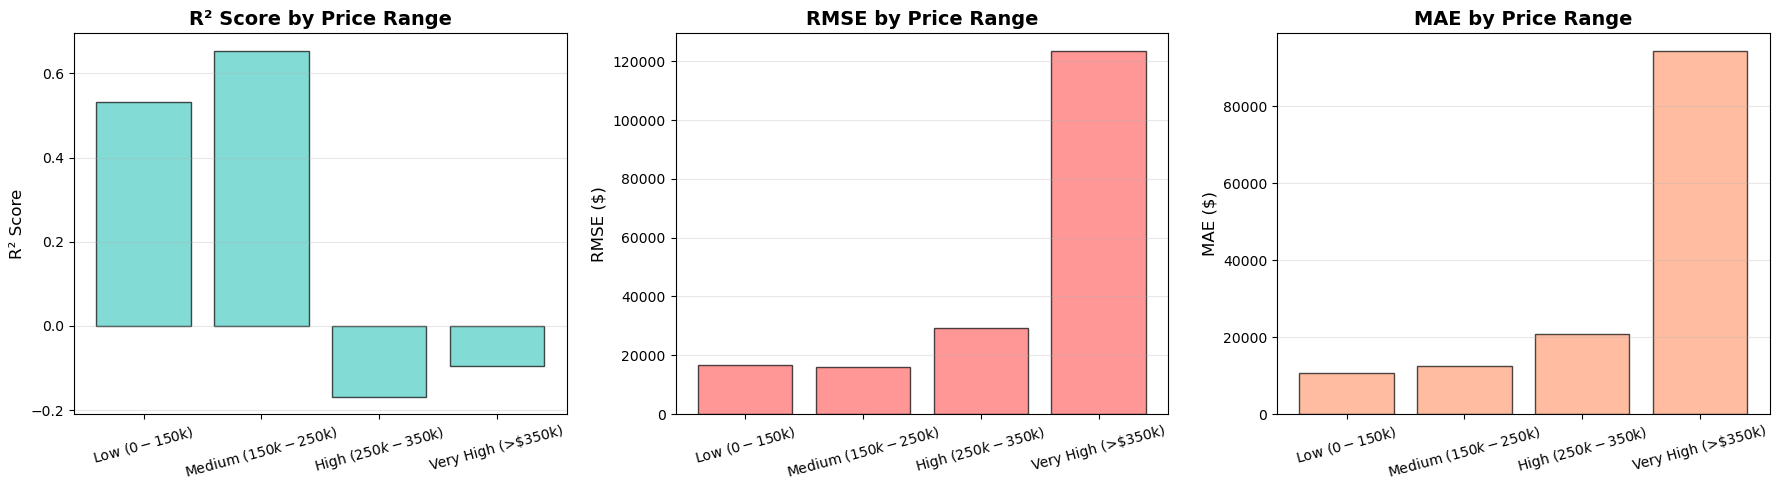

In [82]:
print("\n" + "="*70)
print("PERFORMANCE BY PRICE RANGE")
print("="*70)

# Divide predictions into price ranges
price_ranges = [
    (0, 150000, 'Low ($0-$150k)'),
    (150000, 250000, 'Medium ($150k-$250k)'),
    (250000, 350000, 'High ($250k-$350k)'),
    (350000, np.inf, 'Very High (>$350k)')
]

range_stats = []
for low, high, label in price_ranges:
    mask = (y_test_original >= low) & (y_test_original < high)
    if np.sum(mask) > 0:
        range_rmse = np.sqrt(mean_squared_error(
            y_test_original[mask], 
            y_pred_best_original[mask]
        ))
        range_mae = mean_absolute_error(
            y_test_original[mask], 
            y_pred_best_original[mask]
        )
        range_r2 = r2_score(y_test_original[mask], y_pred_best_original[mask])
        
        range_stats.append({
            'Price Range': label,
            'Count': np.sum(mask),
            'R²': range_r2,
            'RMSE': range_rmse,
            'MAE': range_mae,
            'Mean Error %': (range_mae / y_test_original[mask].mean() * 100)
        })

range_df = pd.DataFrame(range_stats)
print("\n", range_df.to_string(index=False))

# Visualize performance by price range
if len(range_stats) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    ranges = [r['Price Range'] for r in range_stats]
    r2_by_range = [r['R²'] for r in range_stats]
    rmse_by_range = [r['RMSE'] for r in range_stats]
    mae_by_range = [r['MAE'] for r in range_stats]
    
    # R² by range
    axes[0].bar(ranges, r2_by_range, alpha=0.7, edgecolor='black', color='#4ECDC4')
    axes[0].set_ylabel('R² Score', fontsize=12)
    axes[0].set_title('R² Score by Price Range', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=15)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # RMSE by range
    axes[1].bar(ranges, rmse_by_range, alpha=0.7, edgecolor='black', color='#FF6B6B')
    axes[1].set_ylabel('RMSE ($)', fontsize=12)
    axes[1].set_title('RMSE by Price Range', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=15)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # MAE by range
    axes[2].bar(ranges, mae_by_range, alpha=0.7, edgecolor='black', color='#FFA07A')
    axes[2].set_ylabel('MAE ($)', fontsize=12)
    axes[2].set_title('MAE by Price Range', fontsize=14, fontweight='bold')
    axes[2].tick_params(axis='x', rotation=15)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n" + "="*70)
print("COMPREHENSIVE FINAL SUMMARY")
print("="*70)
print(f"\n📊 DATASET INFORMATION")
print(f"  Training samples used: {n_samples} (out of {X_train.shape[0]} total)")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Total features after preprocessing: {X_train.shape[1]}")
print(f"    - Original numeric features: {len(numeric_features)}")
print(f"    - Original categorical features: {len(categorical_features)}")

print(f"\n🏆 BEST MODEL: {best_name} Kernel")
print(f"  Hyperparameters:")
print(f"    - C: {best_model.C}")
print(f"    - epsilon: {best_model.epsilon}")
print(f"    - kernel: {best_model.kernel_type}")
if hasattr(best_model, 'gamma'):
    print(f"    - gamma: {best_model.gamma}")

print(f"\n📈 PERFORMANCE METRICS")
print(f"  Test R² Score: {max(test_r2_linear, test_r2_rbf):.4f}")
print(f"  Test RMSE: ${min(rmse_linear, rmse_rbf):,.2f}")
print(f"  Test MAE: ${min(mae_linear, mae_rbf):,.2f}")
print(f"  Mean Absolute % Error: {percentage_errors.mean():.2f}%")
print(f"  Median Absolute % Error: {np.median(percentage_errors):.2f}%")

print(f"\n🎯 PREDICTION ACCURACY")
print(f"  Average house price: ${y_test_original.mean():,.2f}")
print(f"  RMSE as % of avg price: {min(rmse_linear, rmse_rbf)/y_test_original.mean()*100:.2f}%")
print(f"  Predictions within 10% error: {np.sum(percentage_errors < 10)/len(percentage_errors)*100:.1f}%")
print(f"  Predictions within 20% error: {np.sum(percentage_errors < 20)/len(percentage_errors)*100:.1f}%")

if hasattr(best_model, 'support_vectors') and best_model.support_vectors is not None:
    print(f"\n🔍 SUPPORT VECTORS")
    print(f"  Total support vectors: {len(best_model.support_vectors)}")
    print(f"  % of training data: {len(best_model.support_vectors)/n_samples*100:.2f}%")
    if hasattr(best_model, 'alpha') and hasattr(best_model, 'alpha_star'):
        at_boundary = np.sum((best_model.alpha >= best_model.C * 0.99) | 
                           (best_model.alpha_star >= best_model.C * 0.99))
        print(f"  Support vectors at boundary: {at_boundary} ({at_boundary/len(best_model.alpha)*100:.1f}%)")

print(f"\n💡 MODEL COMPARISON")
print(f"  Linear Kernel: R²={test_r2_linear:.4f}, RMSE=${rmse_linear:,.0f}")
print(f"  RBF Kernel:    R²={test_r2_rbf:.4f}, RMSE=${rmse_rbf:,.0f}")
print(f"  Winner: {best_name} Kernel")

print(f"\n🚀 RECOMMENDATIONS FOR IMPROVEMENT")
print(f"  1. Increase max_iter from 100 to 500-1000 for better convergence")
print(f"  2. Train on full dataset (currently using {n_samples} samples)")
print(f"  3. Perform hyperparameter tuning (grid search on C, epsilon, gamma)")
print(f"  4. Try polynomial kernel for potential non-linear relationships")
print(f"  5. Feature engineering: interaction terms, domain knowledge")
print(f"  6. Ensemble with other regressors (Random Forest, Gradient Boosting)")
print("="*7)


COMPREHENSIVE FINAL SUMMARY

📊 DATASET INFORMATION
  Training samples used: 1168 (out of 1168 total)
  Test samples: 292
  Total features after preprocessing: 242
    - Original numeric features: 36
    - Original categorical features: 43

🏆 BEST MODEL: RBF Kernel
  Hyperparameters:
    - C: 1.0
    - epsilon: 0.1
    - kernel: rbf
    - gamma: 0.004132231404958678

📈 PERFORMANCE METRICS
  Test R² Score: 0.8815
  Test RMSE: $30,143.58
  Test MAE: $15,693.08
  Mean Absolute % Error: 9.18%
  Median Absolute % Error: 5.20%

🎯 PREDICTION ACCURACY
  Average house price: $178,839.81
  RMSE as % of avg price: 16.86%
  Predictions within 10% error: 72.6%
  Predictions within 20% error: 90.8%

🔍 SUPPORT VECTORS
  Total support vectors: 1162
  % of training data: 99.49%
  Support vectors at boundary: 438 (37.7%)

💡 MODEL COMPARISON
  Linear Kernel: R²=-529.6470, RMSE=$2,017,483
  RBF Kernel:    R²=0.8815, RMSE=$30,144
  Winner: RBF Kernel

🚀 RECOMMENDATIONS FOR IMPROVEMENT
  1. Increase max_ite